In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
filepath = "/content/drive/MyDrive/EColi_ML_CSV_files/"
Model_Scores = {}

print(f"Listing files in: {filepath}")
try:
    files_in_dir = os.listdir(filepath)
    print(files_in_dir) 
except FileNotFoundError:
    print(f"Directory not found: {filepath}")
    exit() 

expected_files = {
    "LG_metrics_df.csv": None,
    "RF_metrics_df.csv": None,
    "GB_metrics_df.csv": None,
    "NN_metrics_df": None
}

nn_filename = None
for file in files_in_dir:
    if file.startswith("NN_metrics_df") and file.endswith(".csv"):
        nn_filename = file
        break 

if nn_filename is None:
    print("Error: Neural Network metrics file (starting with NN_metrics_df and ending with .csv) not found in the directory.")
    exit()


LG_metrics = pd.read_csv(filepath+"LG_metrics_df.csv")
RF_metrics = pd.read_csv(filepath+"RF_metrics_df.csv")
GB_metrics = pd.read_csv(filepath+"GB_metrics_df.csv")
DL_metrics = pd.read_csv(filepath+nn_filename) 

Model_Scores["Logistic_Regression"] = LG_metrics
Model_Scores["Random_Forest"] = RF_metrics
Model_Scores["Gradient_Boosted_Trees"] = GB_metrics
Model_Scores["Neural_Network"] = DL_metrics

print("\nSuccessfully loaded all metric dataframes.")

Listing files in: /content/drive/MyDrive/EColi_ML_CSV_files/
['EColi_Merged_df.csv', 'LG_metrics_df.csv', 'RF_metrics_df.csv', 'GB_metrics_df.csv', 'NN_metrics_df_part4.csv']

Successfully loaded all metric dataframes.


In [6]:
Model_Scores['Gradient_Boosted_Trees'].head()

,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_Y,0.861702,0.038462,0.993827,0.500000,0.865591
1,CTZ_G,0.954787,0.750000,0.987654,0.906977,0.960961
2,CTZ_GY,0.962766,0.807692,0.987654,0.913043,0.969697
3,CTX_Y,0.878116,0.421053,1.000000,1.000000,0.866261
4,CTX_G,0.975069,0.934211,0.985965,0.946667,0.982517


In [7]:
combo_list = list(Model_Scores['Gradient_Boosted_Trees']["Drug_combo"].str.split("_", expand= True)[1].unique())
combo_list

['Y', 'G', 'GY']

In [8]:
drug_list = list(Model_Scores['Gradient_Boosted_Trees']["Drug_combo"].str[:3].unique())
drug_list

['CTZ',
 'CTX',
 'AMP',
 'AMX',
 'AMC',
 'TZP',
 'CXM',
 'CET',
 'GEN',
 'TBM',
 'TMP',
 'CIP']

In [9]:
def Best_metrics(model,df):
  print("Selecting Best Scores for model: ",model)
  bestcores_dic = {}
  for drug in drug_list:
    data = df.loc[df["Drug_combo"].str.startswith(drug)]
    max_acc = max(data["Accuracy"])
    drug_combo = data["Drug_combo"][data["Accuracy"] == max_acc].unique()[0]
    R_rec = float(data[data["Drug_combo"] == drug_combo].iloc[:,2].iloc[0])
    S_rec = float(data[data["Drug_combo"] == drug_combo].iloc[:,3].iloc[0])
    R_prec = float(data[data["Drug_combo"] == drug_combo].iloc[:,4].iloc[0])
    S_prec = float(data[data["Drug_combo"] == drug_combo].iloc[:,5].iloc[0])
    bestcores_dic[drug_combo] = [max_acc, R_rec, S_rec, R_prec, S_prec]
    bestscores_df = pd.DataFrame.from_dict(bestcores_dic, orient ='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
    bestscores_df = bestscores_df.rename(columns = {'index':'Drug_combo'})
  return bestscores_df

In [10]:
LG_best_metrics = Best_metrics("Logistic_Regression", Model_Scores["Logistic_Regression"])
LG_best_metrics

Selecting Best Scores for model:  Logistic_Regression


,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision
0,CTZ_GY,0.938830,0.711538,0.975309,0.822222,0.954683
1,CTX_G,0.955679,0.868421,0.978947,0.916667,0.965398
2,AMP_G,0.853503,0.924370,0.631579,0.887097,0.727273
3,AMX_G,0.863014,0.857143,0.872093,0.912000,0.797872
4,AMC_GY,0.773810,0.656863,0.824786,0.620370,0.846491
5,TZP_G,0.916667,0.150000,0.965190,0.214286,0.947205
6,CXM_G,0.853723,0.679612,0.919414,0.760870,0.883803
7,CET_G,0.898089,0.805970,0.966667,0.947368,0.870000
8,GEN_G,0.968085,0.872727,0.984424,0.905660,0.978328
9,TBM_G,0.840764,0.702128,0.900000,0.750000,0.876106


In [11]:
def make_GY(bestscores_df):
  bestscores_df["G"] = " "
  bestscores_df["Y"] = " "

  split_c = bestscores_df["Drug_combo"].str.split("_", expand=True)
  i=0
  while i < len(split_c[1]):
    split_each_c = [x for x in split_c[1][i]]
    for g in split_each_c:
      if "G" in split_each_c:
        bestscores_df.at[i,"G"] = 1
      else:
        bestscores_df.at[i,"G"] = 0
    for y in split_each_c:
      if "Y" in split_each_c:
        bestscores_df.at[i,"Y"] = 1
      else:
        bestscores_df.at[i,"Y"] = 0
    i += 1
  bestscores_df["Drug_combo"] = bestscores_df["Drug_combo"].map(lambda x: x.rstrip('_GY'))
  bestscores_df.rename(columns={"Drug_combo": "Drug"}, inplace = True)

  return bestscores_df

In [12]:
GY_LG_best_metrics = make_GY(LG_best_metrics)
GY_LG_best_metrics

,Drug,Accuracy,R_recall,S_recall,R_precision,S_precision,G,Y
0,CTZ,0.938830,0.711538,0.975309,0.822222,0.954683,1,1
1,CTX,0.955679,0.868421,0.978947,0.916667,0.965398,1,0
2,AMP,0.853503,0.924370,0.631579,0.887097,0.727273,1,0
3,AMX,0.863014,0.857143,0.872093,0.912000,0.797872,1,0
4,AMC,0.773810,0.656863,0.824786,0.620370,0.846491,1,1
5,TZP,0.916667,0.150000,0.965190,0.214286,0.947205,1,0
6,CXM,0.853723,0.679612,0.919414,0.760870,0.883803,1,0
7,CET,0.898089,0.805970,0.966667,0.947368,0.870000,1,0
8,GEN,0.968085,0.872727,0.984424,0.905660,0.978328,1,0
9,TBM,0.840764,0.702128,0.900000,0.750000,0.876106,1,0


In [13]:
Best_metrics_models = {}
for model, df in Model_Scores.items():
  Model_best_metrics = Best_metrics(model, df)

  GY_coded_best = make_GY(Model_best_metrics)
  print(GY_coded_best)

  Best_metrics_models[model] = GY_coded_best

Selecting Best Scores for model:  Logistic_Regression
   Drug  Accuracy  R_recall  S_recall  R_precision  S_precision  G  Y
0   CTZ  0.938830  0.711538  0.975309     0.822222     0.954683  1  1
1   CTX  0.955679  0.868421  0.978947     0.916667     0.965398  1  0
2   AMP  0.853503  0.924370  0.631579     0.887097     0.727273  1  0
3   AMX  0.863014  0.857143  0.872093     0.912000     0.797872  1  0
4   AMC  0.773810  0.656863  0.824786     0.620370     0.846491  1  1
5   TZP  0.916667  0.150000  0.965190     0.214286     0.947205  1  0
6   CXM  0.853723  0.679612  0.919414     0.760870     0.883803  1  0
7   CET  0.898089  0.805970  0.966667     0.947368     0.870000  1  0
8   GEN  0.968085  0.872727  0.984424     0.905660     0.978328  1  0
9   TBM  0.840764  0.702128  0.900000     0.750000     0.876106  1  0
10  TMP  0.904459  0.871429  0.931034     0.910448     0.900000  1  0
11  CIP  0.928191  0.858824  0.948454     0.829545     0.958333  1  0
Selecting Best Scores for model:  Ra

In [14]:
def barplot(metric_col, subplot_axis, label_show = True):
  for model, df in Best_metrics_models.items():
    X_axis = np.arange(len(drug_list))
    X_labels = drug_list

    Y_axis = np.arange(0,1.2,0.2)

    subplot_axis.set_ylabel(metric_col, fontsize = 14)
    subplot_axis.set_ylim(bottom=0, top=1)

    subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)
    subplot_axis.xaxis.set_ticks(X_axis)
    subplot_axis.margins(x=0)

    if label_show == False:
      subplot_axis.tick_params(left = True, right = False , labelleft = True , labelbottom = False, bottom = True)

    if model == "Logistic_Regression":
      X_axis = X_axis - 0.3
      color = "plum"
      label = "LG"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.2, align = 'center', color = color, label = label, edgecolor="gray")
    elif model == "Random_Forest":
      X_axis = X_axis - 0.1
      color = "cadetblue"
      label = "RF"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.2, align = 'center', color = color, label = label, edgecolor="gray")
    elif model == "Gradient_Boosted_Trees":
      X_axis = X_axis + 0.1
      color = "goldenrod"
      label = "GB"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.2, align = 'center', color = color, label = label, edgecolor="gray")
    elif model == "Neural_Network":
      X_axis = X_axis + 0.3
      color = "steelblue"
      label = "GB"
      subplot_axis.bar(X_axis, list(df[metric_col]), width =.2, align = 'center', color = color, label = label, edgecolor="gray")
  return

<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)


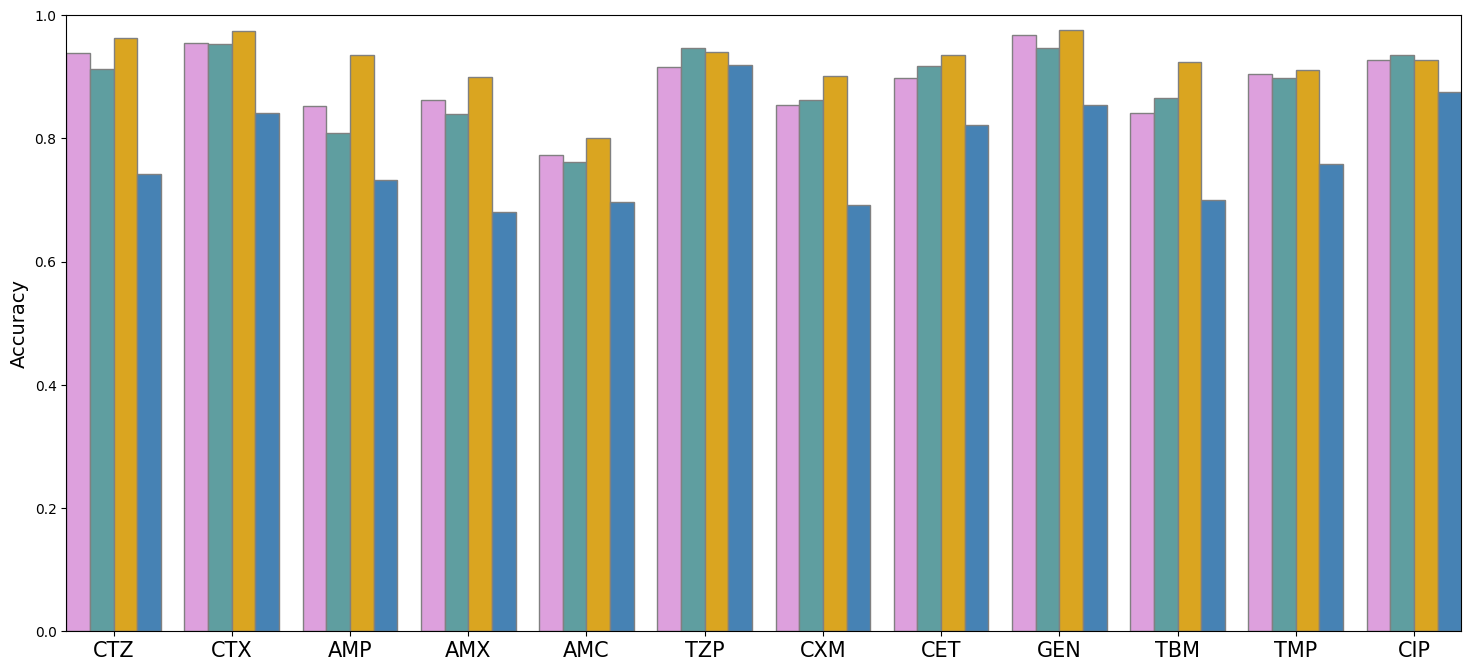

In [15]:
figure, subs = plt.subplots(1, 1,figsize = (18,8))
acc_plot = barplot("Accuracy",subs,label_show=True)

In [16]:
def GY_gridplot(drug,subplot_axis, label_show = True, title_pos = -0.2):
  Y_list = []
  G_list = []

  for model, df in Best_metrics_models.items():
    for drug_name in df["Drug"]:
      if drug_name == drug:
        Y_list.append(int(df["Y"][df["Drug"]==drug].iloc[0]))
        G_list.append(int(df["G"][df["Drug"]==drug].iloc[0]))

  Drug_GY_list = [Y_list, G_list]

  plt.yticks(np.arange(2), ["Year", "Accessory Genes"])
  if label_show == False:
      subplot_axis.tick_params(left = False, labelleft = False)

  orig_map = plt.colormaps['gray']
  reversed_map = orig_map.reversed()
  subplot_axis.imshow(Drug_GY_list, cmap = reversed_map)

  subplot_axis.axvline(x=0.5)
  subplot_axis.axvline(x=1.5)
  subplot_axis.axvline(x=2.5)
  subplot_axis.axhline(y=0.5)
  subplot_axis.axhline(y=1.5)
  subplot_axis.set_title(drug, fontsize= 15, y=title_pos)
  subplot_axis.tick_params(
    axis = 'x',
    which = 'both',
    bottom = False,
    top = False,
    labelbottom = False)
  return [Y_list, G_list]

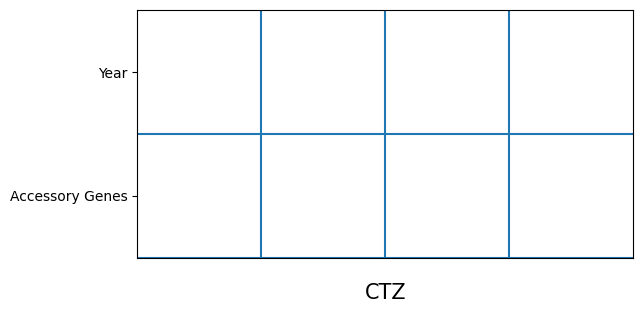

In [17]:
figure, subs = plt.subplots()
CTZ_gridplot = GY_gridplot("CTZ",subs, label_show=True)

<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)
<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)
<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)
<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  subplot_axis.xaxis.set_ticklabels(X_labels, fontsize = 15)
<ipython-input-14-da1b4b1db9ec>:11: UserWarning: set_ticklabels() should only be used with a fixed n

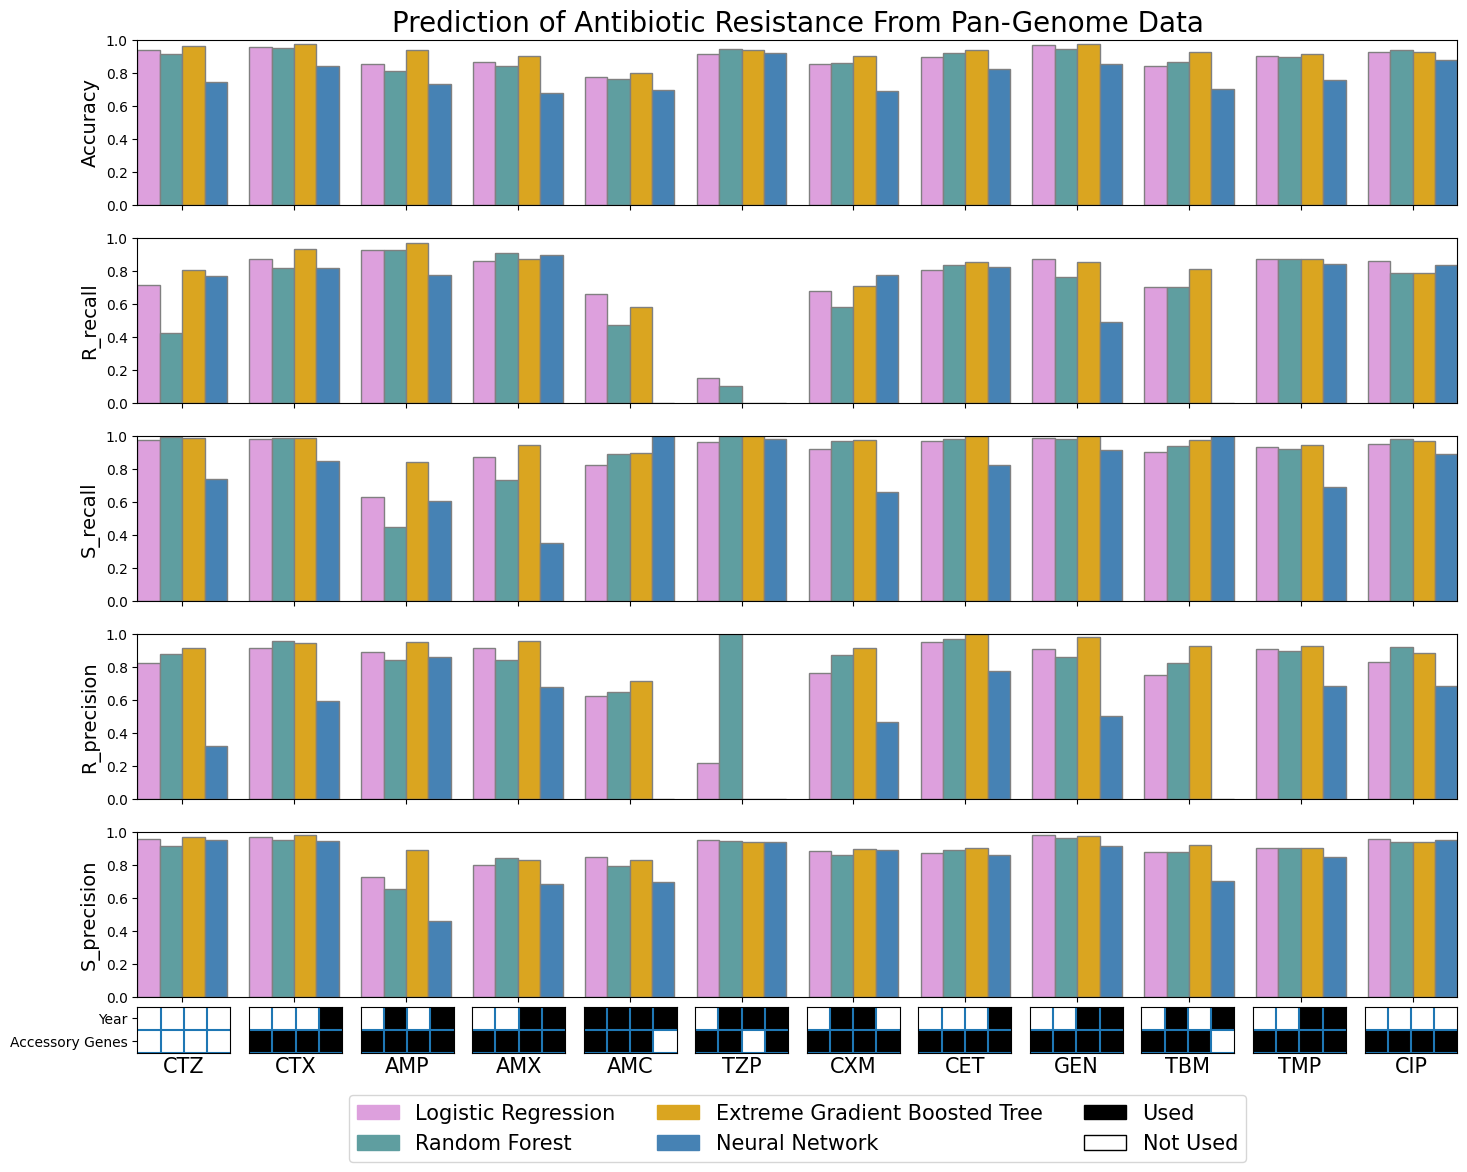

In [18]:
fig = plt.figure(figsize = (24,15), constrained_layout=False)

gs1 = fig.add_gridspec(nrows=6, ncols=12, left=0.05, right=0.6, wspace=0.07)
acc_axis = fig.add_subplot(gs1[0, :])
acc_axis.set_title('Prediction of Antibiotic Resistance From Pan-Genome Data', fontsize = 20)
acc_plot = barplot("Accuracy",acc_axis, label_show = False)

R_metric_axis = fig.add_subplot(gs1[1, :])
R_metric_plot = barplot('R_recall',R_metric_axis, label_show = False)

S_metric_axis = fig.add_subplot(gs1[2, :])
S_metric_plot = barplot('S_recall',S_metric_axis, label_show = False)

R_metric_axis = fig.add_subplot(gs1[3, :])
R_metric_plot = barplot('R_precision',R_metric_axis, label_show = False)

S_metric_axis = fig.add_subplot(gs1[4, :])
S_metric_plot = barplot('S_precision',S_metric_axis, label_show = False)

gs2 = fig.add_gridspec(nrows=1, ncols=12, top=0.44,bottom=0,left=0.05, right=0.6, wspace=0.2)
i=0
while (i< len(drug_list)):
  for drug in drug_list:
    if i == 0:
      Drug_grid = fig.add_subplot(gs2[-1, i])
      drug_GY = GY_gridplot(drug, Drug_grid, label_show=True, title_pos=-0.6)
      i+=1
    else:
      Drug_grid = fig.add_subplot(gs2[-1, i])
      drug_GY = GY_gridplot(drug, Drug_grid, label_show=False, title_pos=-0.6)
      i+=1

legend_elements = [Patch(facecolor='plum', edgecolor='plum', label='Logistic Regression'),
                   Patch(facecolor='cadetblue', edgecolor='cadetblue', label='Random Forest'),
                   Patch(facecolor='goldenrod', edgecolor='goldenrod', label='Extreme Gradient Boosted Tree'),
                   Patch(facecolor='steelblue', edgecolor='steelblue', label='Neural Network'),
                   Patch(facecolor='black', edgecolor="black", label='Used'),
                   Patch(facecolor='white', edgecolor="black",label='Not Used')]

plt.legend(handles=legend_elements,loc = 'lower center', bbox_to_anchor=(-6.1, -1), prop ={'size': 15}, borderaxespad=-3, ncol = 3)

plt.savefig('/content/drive/MyDrive/EColi_ML_Plots/Final_Metrics_Plot.jpg',dpi=400, bbox_inches="tight")